# Stock Predictor for Apple stock (APPL)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import keras
%matplotlib inline

Using Theano backend.


In [2]:
prices_dataset =  pd.read_csv('AAPL.csv', header=0)
print prices_dataset.isnull().any().any()  #Check if there are any NaN values
prices_dataset = prices_dataset.drop(['Open','High','Low'], axis = 1)
prices_dataset.head()

False


,Date,Close,Adj Close,Volume
0,2/7/2009,140.020004,18.066357,92619800
1,6/7/2009,138.610001,17.884430,124672100
2,7/7/2009,135.399994,17.470257,115399200
3,8/7/2009,137.220001,17.705082,143982300
4,9/7/2009,136.360001,17.594120,85756300


Read the PE_ratio and join it with the dataset dataframe above. Since P/E is a quarterly figure we will join it with the dates that fall within that quarter.

In [3]:
PE_ratio =  pd.read_csv('APPL_Price_to_Earnings.csv', header=0)

from datetime import datetime as dt
#assing P/E ratio to each date within the quarter
PE = pd.Series(data = 0.0, index = prices_dataset.index, dtype = float)

for inx in range(len(prices_dataset.index)):
    for jnx in range(len(PE_ratio.index)): 
        if dt.strptime(prices_dataset['Date'][inx], "%d/%m/%Y")>dt.strptime(PE_ratio['Dates'][jnx], "%d/%m/%Y"):
            PE[inx] = PE_ratio['Price to Earnings'][jnx]

prices_dataset['PE'] = PE

This data set ranges from 2 July 2009 to 30 June 2017 which is a total of 8 years and consists of the closing price, the adjusted close, volume and P/E ratio. We will use these values to form our features. Our features are a Adjusted close price to a 5 day moving average of Adjusted Close, MACD(Moving average convergence divergence) and the P/E ratio. The adjusted closing price is the price which is adjusted for corporate actions such as stock splits in comparison with the day's closing price. The MACD is a technical indicator used to indicate momentum of the stock. A high positive value indicates a strong upward trend while a negative value with high absolute value indicates a strong downtrend. For more information you can refer to http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_average_convergence_divergence_macd    
PE ratio is a common metric to analyse value of the stock. It is the ratio of the price of the stock to the quarterly earnings of the company. 

In [4]:
# We will form our features. On top of it we will also form a measure of daily returns.
daily_returns = prices_dataset['Adj Close'].pct_change(1) # 1 for ONE DAY lookback
prices_dataset['daily_returns'] = daily_returns+1.0 #we want pct change!!

#moving average of the adjusted close
prices_dataset['AdjClose_ma'] = prices_dataset['Adj Close'].rolling(window=5,center=False).mean() #cancel out noise

#Calculate AdjClose/moving average. This shall be one of our features
prices_dataset['AdjClose_to_ma'] = prices_dataset['Adj Close']/prices_dataset['AdjClose_ma']

#Calculate MACD. EWMA26 is the 26 day exponentially weighted moving average.
EWMA26 = prices_dataset['Adj Close'].ewm(ignore_na=False,span=26,min_periods=26,adjust=True).mean()
EWMA12 = prices_dataset['Adj Close'].ewm(ignore_na=False,span=12,min_periods=12,adjust=True).mean()
prices_dataset['MACD'] = EWMA12 - EWMA26

#drop na values
APPL_df = prices_dataset.dropna(axis=0, how='any')
APPL_df = (APPL_df.reset_index()).drop('index',axis = 1)
APPL_df

,Date,Close,Adj Close,Volume,PE,daily_returns,AdjClose_ma,AdjClose_to_ma,MACD
0,7/8/2009,165.509995,21.355257,96838700,16.22,1.009761,21.328419,1.001258,0.499441
1,10/8/2009,164.720001,21.253325,75073600,16.22,0.995227,21.284292,0.998545,0.483160
2,11/8/2009,162.830002,21.009460,88835600,16.22,0.988526,21.214100,0.990354,0.447396
3,12/8/2009,165.309998,21.329453,111267800,16.22,1.015231,21.219262,1.005193,0.437357
4,13/8/2009,168.419998,21.730726,109995200,16.22,1.018813,21.335644,1.018517,0.453587
5,14/8/2009,166.779999,21.519119,76454000,16.22,0.990262,21.368417,1.007053,0.445532
6,17/8/2009,159.589996,20.591417,131095300,16.22,0.956889,21.236035,0.969645,0.365796
7,18/8/2009,164.000000,21.160429,107788100,16.22,1.027633,21.266229,0.995025,0.341384
8,19/8/2009,164.600006,21.237843,103317900,16.22,1.003658,21.247907,0.999526,0.324122
9,20/8/2009,166.330002,21.461061,85507800,16.22,1.010510,21.193974,1.012602,0.323594


# Describing the data

In [5]:
APPL_df.describe()

,Close,Adj Close,Volume,PE,daily_returns,AdjClose_ma,AdjClose_to_ma,MACD
count,1989.000000,1989.000000,1.989000e+03,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,295.651041,76.171408,9.139651e+07,14.686742,1.001096,76.047747,1.001979,0.451672
std,181.015275,33.414377,6.023687e+07,2.935007,0.016183,33.370859,0.017879,1.437241
min,90.279999,20.591417,1.147590e+07,9.900000,0.876442,21.193974,0.911220,-4.147545
25%,117.650002,47.714188,4.560110e+07,12.180000,0.993074,47.530966,0.991842,-0.228604
50%,254.239990,73.118080,7.887040e+07,14.610000,1.000905,73.101788,1.002557,0.421219
75%,449.730042,104.820999,1.191561e+08,16.760000,1.009961,104.937451,1.012915,1.214963
max,702.100037,156.100006,4.702495e+08,20.410000,1.088741,154.837997,1.064582,4.785038


From the description above, the PE is quite large indicating that apple is a popular stock. Investors are willing to pay an average of $14.68 per dollar earned by apple. A lower PE makes the stock more desirable. It also seems symmetrically distributed with mean being close to median. The MACD seems to be quite symetrically distributed having a mean of 0.5 and max and min values of 4.78 and -4.14 respectively. This might mean there are different periods with uptrends and downtrends in the stock price. As for AdjClose to moving average, it is also quite symetric since the median and mean values are very close. The moving average portion has taken out noise from the data. We test for normality below.

In [6]:
import scipy.stats as stats
print stats.normaltest(APPL_df['PE'])
print stats.normaltest(APPL_df['AdjClose_to_ma'])
print stats.normaltest(APPL_df['MACD'])

NormaltestResult(statistic=165.10177120147955, pvalue=1.4080105449880001e-36)
NormaltestResult(statistic=115.19555086827263, pvalue=9.6739526875620546e-26)
NormaltestResult(statistic=39.3268152566596, pvalue=2.8859617557459964e-09)


With such small p-values we can safely say that that the data set is not normal. This is not surprising since there is an increasing trend in the prices. 

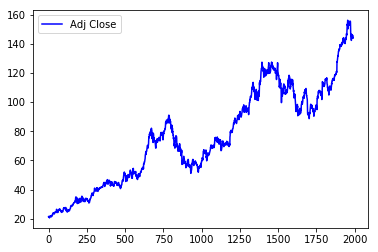

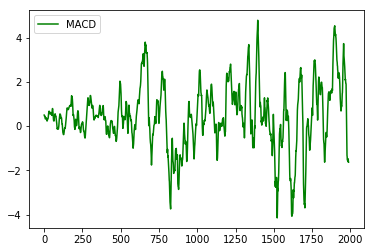

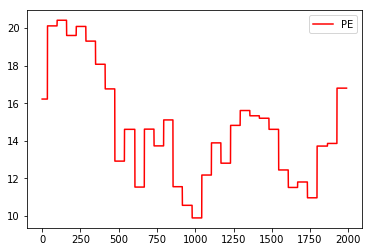

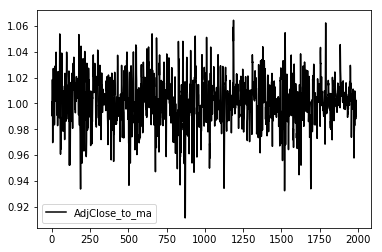

In [7]:
import matplotlib.pyplot as plt2

plt2.plot(APPL_df['Adj Close'],color='blue', label='Adj Close')
plt2.legend(loc='best')
plt2.show()

plt2.plot(APPL_df['MACD'],color='green', label='MACD')
plt2.legend(loc='best')
plt2.show()

plt2.plot(APPL_df['PE'],color='red', label='PE')
plt2.legend(loc='best')
plt2.show()

plt2.plot(APPL_df['AdjClose_to_ma'],color='black', label='AdjClose_to_ma')
plt2.legend(loc='best')
plt2.show()

The adjusted closing prices have increased over the years showing that apple stock is quite profitable. From the descriptive stats, one would have obtained a 1% daily return everyday on average for the past 9 years. The MACD indicator suggests that there are times of strong uptrends and strong downtrends. There does not seem to be any discernable pattern in the PE. We will use our machine learning algorithm to find how these features influence each other.

We will fix a random number seed to ensure our results are reproducible. LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. Looking at our data a good range would be from -1-to-1.

In [8]:
np.random.seed(10)
FeaturesData = APPL_df[['MACD','AdjClose_to_ma','PE','Adj Close']].copy()
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
def normalize_data(df):
    df['MACD'] = min_max_scaler.fit_transform(df.MACD.values.reshape(-1,1))
    df['AdjClose_to_ma'] = min_max_scaler.fit_transform(df.AdjClose_to_ma.values.reshape(-1,1))
    df['PE'] = min_max_scaler.fit_transform(df.PE.values.reshape(-1,1))
    df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df
df = normalize_data(FeaturesData)
df.head()

,MACD,AdjClose_to_ma,PE,Adj Close
0,0.520229,0.587096,0.601332,0.005637
1,0.518406,0.569405,0.601332,0.004885
2,0.514402,0.515992,0.601332,0.003085
3,0.513278,0.612753,0.601332,0.005446
4,0.515095,0.699635,0.601332,0.008408


We want to use the values from 10 days of the features to predict the adjusted close price the next day. So given the values of MACD, AdjClose to ma and P/E at time t-9,t-8,...t, we want to predict the adj close price at time t+1. We also want to split our data into training and testing sets. Since this is a timeseries we cannot use shuffling in a cross validation. Below is function to split our data into 70% training set and 30% testing set. We will train a model on each of them and take an average as our final model.

We now prepare our data in the correct format. At time t we have 10 values of MACD, AdjClose to moving average and PE ratio and one value of adj close at time t+1.   
Furthermore the LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

In [9]:
def load_data(stock, seq_len=10):
    amount_of_features = len(stock.columns) # 4
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 10days
    
    result = np.array(result)
    row = round(0.7 * result.shape[0]) # 70% split
    train = result[:int(row), :] # 70% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [10]:
X_train, y_train, X_test, y_test = load_data(df)
print (X_train[0], y_train[0])
print df[0:11]

(array([[ 0.52022867,  0.58709635,  0.60133206,  0.00563684],
       [ 0.51840603,  0.5694046 ,  0.60133206,  0.00488462],
       [ 0.5144023 ,  0.51599153,  0.60133206,  0.00308499],
       [ 0.51327836,  0.61275251,  0.60133206,  0.00544641],
       [ 0.51509539,  0.69963521,  0.60133206,  0.00840765],
       [ 0.51419364,  0.62487802,  0.60133206,  0.00684608],
       [ 0.50526721,  0.38096101,  0.60133206,  0.        ],
       [ 0.50253422,  0.54645164,  0.60133206,  0.00419908],
       [ 0.50060181,  0.57580305,  0.60133206,  0.00477037],
       [ 0.50054266,  0.66106349,  0.60133206,  0.00641763]]), 0.0091694335331024834)
        MACD  AdjClose_to_ma        PE  Adj Close
0   0.520229        0.587096  0.601332   0.005637
1   0.518406        0.569405  0.601332   0.004885
2   0.514402        0.515992  0.601332   0.003085
3   0.513278        0.612753  0.601332   0.005446
4   0.515095        0.699635  0.601332   0.008408
5   0.514194        0.624878  0.601332   0.006846
6   0.505267  

Our y-value is the adjusted closing price value at time t+1. Before we train our model, we shall remove the last column from the X.

In [11]:
new_X_train = np.empty([len(X_train),10,3])
for i in range(len(X_train)):
    for j in range(10):
        new_row = np.delete(X_train[i][j],3)
        new_X_train[i][j] = new_row

new_X_test = np.empty([len(X_test),10,3])
#new_X_train = np.reshape(new_X_train,(1385,10,3))
for i in range(len(X_test)):
    for j in range(10):
        new_row = np.delete(X_test[i][j],3)
        new_X_test[i][j] = new_row

print new_X_train[0][0]
print new_X_test[0][0]

[ 0.52022867  0.58709635  0.60133206]
[ 0.73351696  0.60883586  0.51665081]


Let's train the LSTM network for this problem.   

The network has 2 visible layers with 10 inputs, a hidden layer with 32 LSTM blocks and another with 16 LSTM blocks or neurons, and an output layer that makes 16 value prediction and 1 value prediction. The default sigmoid activation function is used for the LSTM blocks. We will use a dropout of 0.2.

Each epoch is a forward pass and back pass of all of the training examples, i.e. the batch size.   
Dropout is a regularization technique for reducing overfitting in neural networks. So we simply throw away 20% of the results to make the model more stochastic. We shall use a batch size of 50 and epoch of 90.

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
#from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier

In [14]:
# Function to create model, required for KerasClassifier
def create_model(d=0.2,InputShape = (10,3)):
	# create model
    
    model = Sequential()
    model.add(LSTM(32, input_shape= InputShape, return_sequences=True))
    model.add(Dropout(d))
    model.add(Dense(16))

    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

    return model

# create model
model = create_model()
start = time.time()
model.fit(new_X_train,y_train,batch_size=50,epochs=90,validation_split=0.1,verbose=1)
print ('compilation time : ', time.time() - start)

# define the grid search parameters
#batch_size = [40, 50, 70]
#epochs = [10, 50, 100]
#param_grid = dict(batch_size=batch_size, epochs=epochs)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
#grid_result = grid.fit(new_X_train, y_train)

# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Train on 1246 samples, validate on 139 samples
Epoch 1/90
1246/1246 [==============================] - 0s - loss: 0.0202 - acc: 0.0000e+00 - val_loss: 0.1211 - val_acc: 0.0000e+00
Epoch 2/90
1246/1246 [==============================] - 0s - loss: 0.0125 - acc: 0.0000e+00 - val_loss: 0.1431 - val_acc: 0.0000e+00
Epoch 3/90
1246/1246 [==============================] - 0s - loss: 0.0115 - acc: 0.0000e+00 - val_loss: 0.1452 - val_acc: 0.0000e+00
Epoch 4/90
1246/1246 [==============================] - 0s - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0983 - val_acc: 0.0000e+00
Epoch 5/90
1246/1246 [==============================] - 0s - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.1102 - val_acc: 0.0000e+00
Epoch 6/90
1246/1246 [==============================] - 1s - loss: 0.0099 - acc: 0.0000e+00 - val_loss: 0.1193 - val_acc: 0.0000e+00
Epoch 7/90
1246/1246 [==============================] - 1s - loss: 0.0100 - acc: 0.0000e+00 - val_loss: 0.0947 - val_acc: 0.0000e+00
Epoch 8/90
1246/1246 [

1246/1246 [==============================] - 0s - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.0914 - val_acc: 0.0000e+00
Epoch 62/90
1246/1246 [==============================] - 1s - loss: 0.0049 - acc: 0.0000e+00 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 63/90
1246/1246 [==============================] - 1s - loss: 0.0049 - acc: 0.0000e+00 - val_loss: 0.0712 - val_acc: 0.0000e+00
Epoch 64/90
1246/1246 [==============================] - 1s - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.1480 - val_acc: 0.0000e+00
Epoch 65/90
1246/1246 [==============================] - 1s - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.0908 - val_acc: 0.0000e+00
Epoch 66/90
1246/1246 [==============================] - 1s - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.0819 - val_acc: 0.0000e+00
Epoch 67/90
1246/1246 [==============================] - 1s - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0952 - val_acc: 0.0000e+00
Epoch 68/90
1246/1246 [==============================] - 1s - loss: 0.0045

Now that we have trained our model, let's evaluate it.

In [25]:
import math
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (float(testScore[0]), float(math.sqrt(testScore[0]))))



model_score(model, new_X_train, y_train, new_X_test, y_test)

Train Score: 0.01173 MSE (0.11 RMSE)
Test Score: 0.17485 MSE (0.42 RMSE)


To visualise the predictions of this model with the test data and the robustness of the model.

C:\Users\User\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


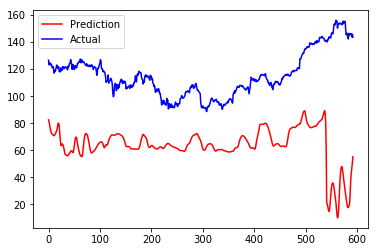

In [26]:
pred = model.predict(new_X_test)
Predictions = min_max_scaler.inverse_transform(pred)
Actual = min_max_scaler.inverse_transform(y_test)

import matplotlib.pyplot as plt2

plt2.plot(Predictions,color='red', label='Prediction')
plt2.plot(Actual,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

The model is not very accurate and it can be improved by doing a timeseries split of the data and averaging the fitted models. Looking at the graph towards the end there is a significant drop of the stock price withour predictions. This may be due to the sudden increase in P/E ratio from our data set. We re-train another model without P/E ratio.

In [32]:
new_X_train2 = np.empty([len(new_X_train),10,2])
for i in range(len(new_X_train)):
    for j in range(10):
        new_row = np.delete(new_X_train[i][j],2)
        new_X_train2[i][j] = new_row

new_X_test2 = np.empty([len(new_X_test),10,2])
#new_X_train = np.reshape(new_X_train,(1385,10,3))
for i in range(len(new_X_test)):
    for j in range(10):
        new_row = np.delete(new_X_test[i][j],2)
        new_X_test2[i][j] = new_row

print new_X_train2[0][0]
print new_X_test2[0][0]

[ 0.52022867  0.58709635]
[ 0.73351696  0.60883586]


In [43]:
def create_model(d=0.2,InputShape = (10,3)):
	# create model
    
    model = Sequential()
    model.add(LSTM(32, input_shape= InputShape, return_sequences=True))
    model.add(Dropout(d))
    model.add(Dense(16))

    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

    return model

# create model
model2 = create_model(InputShape = (10,2))
start = time.time()
model2.fit(new_X_train2,y_train,batch_size=50,epochs=90,validation_split=0.1,verbose=1)
print ('compilation time : ', time.time() - start)

Train on 1246 samples, validate on 139 samples
Epoch 1/90
1246/1246 [==============================] - 0s - loss: 0.0277 - acc: 0.0000e+00 - val_loss: 0.1264 - val_acc: 0.0000e+00
Epoch 2/90
1246/1246 [==============================] - 0s - loss: 0.0212 - acc: 0.0000e+00 - val_loss: 0.0978 - val_acc: 0.0000e+00
Epoch 3/90
1246/1246 [==============================] - 0s - loss: 0.0207 - acc: 0.0000e+00 - val_loss: 0.0892 - val_acc: 0.0000e+00
Epoch 4/90
1246/1246 [==============================] - 0s - loss: 0.0211 - acc: 0.0000e+00 - val_loss: 0.1533 - val_acc: 0.0000e+00
Epoch 5/90
1246/1246 [==============================] - 0s - loss: 0.0206 - acc: 0.0000e+00 - val_loss: 0.1276 - val_acc: 0.0000e+00
Epoch 6/90
1246/1246 [==============================] - 0s - loss: 0.0195 - acc: 0.0000e+00 - val_loss: 0.1299 - val_acc: 0.0000e+00
Epoch 7/90
1246/1246 [==============================] - 0s - loss: 0.0204 - acc: 0.0000e+00 - val_loss: 0.1357 - val_acc: 0.0000e+00
Epoch 8/90
1246/1246 [

1246/1246 [==============================] - 1s - loss: 0.0137 - acc: 0.0000e+00 - val_loss: 0.1081 - val_acc: 0.0000e+00
Epoch 62/90
1246/1246 [==============================] - 1s - loss: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1172 - val_acc: 0.0000e+00
Epoch 63/90
1246/1246 [==============================] - 1s - loss: 0.0137 - acc: 0.0000e+00 - val_loss: 0.1205 - val_acc: 0.0000e+00
Epoch 64/90
1246/1246 [==============================] - 1s - loss: 0.0137 - acc: 0.0000e+00 - val_loss: 0.1159 - val_acc: 0.0000e+00
Epoch 65/90
1246/1246 [==============================] - 1s - loss: 0.0137 - acc: 0.0000e+00 - val_loss: 0.1134 - val_acc: 0.0000e+00
Epoch 66/90
1246/1246 [==============================] - 1s - loss: 0.0136 - acc: 0.0000e+00 - val_loss: 0.1031 - val_acc: 0.0000e+00
Epoch 67/90
1246/1246 [==============================] - 2s - loss: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1190 - val_acc: 0.0000e+00
Epoch 68/90
1246/1246 [==============================] - 1s - loss: 0.0135

In [44]:
model_score(model2, new_X_train2, y_train, new_X_test2, y_test)

Train Score: 0.02257 MSE (0.15 RMSE)
Test Score: 0.15841 MSE (0.40 RMSE)


C:\Users\User\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


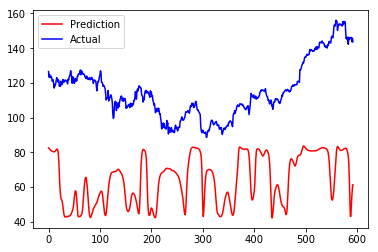

In [45]:
pred2 = model2.predict(new_X_test2)
Predictions2 = min_max_scaler.inverse_transform(pred2)
Actual = min_max_scaler.inverse_transform(y_test)

import matplotlib.pyplot as plt2

plt2.plot(Predictions2,color='red', label='Prediction')
plt2.plot(Actual,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

This model has a slightly lower RMSE. We can improve its accuracy by one of the following ways.  
1) Having more data
2) Using a timeseries split and train multiple models and averaging.   

To measure it's robustness, let's take the test data and vary it slightly by 1%.

In [66]:
Result1 = model2.predict(new_X_test2)
Result2 = model2.predict(new_X_test2*1.01)

print np.mean((Result2 - Result1)/ Result1)

0.00493111


A 1% change in the values gives us a 0.4% change on average in this sample data. This suggests that the model is robust. There are no huge deviations.

In [ ]:
nx, ny, nz =  new_X_train.shape
X_train_dataset = new_X_train.reshape((nx,ny*nz))

In [ ]:
from sklearn.svm import SVR
clf = SVR(C=1.0, kernel='rbf', degree=2, epsilon=0.2)
clf.fit(X_train_dataset, y_train) 

In [ ]:
nx1, ny1, nz1 =  new_X_test.shape
X_test_dataset = new_X_test.reshape((nx1,ny1*nz1))
y_predicted = clf.predict(X_test_dataset)

In [ ]:
y_predicted= min_max_scaler.inverse_transform(y_predicted)

In [ ]:
import matplotlib.pyplot as plt2
Actual = min_max_scaler.inverse_transform(y_test)
plt2.plot(y_predicted,color='red', label='Prediction')
plt2.plot(Actual,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()